### This notebook comprises of the code to train the RandomForest Regressor that uses financial statement values (pca) and some financial ratios to predict adj_close price 

In [3]:
import pandas as pd 
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from matplotlib import pyplot
from xgboost import plot_importance

Some important financial ratios:
1) Working capital ratio = Current assets/ current liabilities.
A measure of liquidity, how easily a company can turn assets into cash to pay short-term obligations.
2) Cash Flows per Share = (Operating Cash Flow – Preferred Dividends) / Common Shares Outstanding
Harder to manipulate thatn Earnings per Share.
3) Debt To Equity = Total Liabilitys/Shareholder's equity.
Whether the company is borrowing more than it can pay back, long term view. 
4) Return on equity (Earnings - Dividends)/Shareholder's Equity


In [2]:
data = pd.read_csv('data/vnd_financial_statement.csv').sort_values(by=['ticker','name','date'],ascending=False)
data = data.drop_duplicates().dropna(subset=['name']).reset_index(drop=True)
data.shape

(6543784, 5)

In [3]:
tickers = list(sorted(set(data['ticker'])))
names = list(sorted(set(data['name'])))
dates = list(sorted(set(data['date']),reverse=True))
len(tickers),len(names),len(dates)

(794, 576, 83)

In [4]:
index = pd.MultiIndex(levels=[[],[]],
                          codes=[[],[]],
                          names=['date', 'ticker'])

df = pd.DataFrame(columns=names,index=index)
print(df.shape)
df.head()

(0, 576)


,,Increase/(decrease) in receivables,Profit after tax deducted of Funds,(Increase)/decrease in payables,Account Receivable,Account receivable,Accrued expenses,Acumulated Depreation and Amortization,Adjustments,Advances to employees,Allowance for balances with and loans to other credit institutions,...,Unearned premium reserve,Unrealised foreign exchange gain/(loss),Unrealized Revenue (Long term),Unrealized gain,Value added Tax,convertible bond,receivables on securities transaction settlement of clients,short term issue bonds,​Bid Guarantee,​Performance Guarantee
date,ticker,,,,,,,,,,,,,,,,,,,,,


In [5]:
data.head()

,ticker,name,code,value,date
0,YSC,convertible bond,13343.0,0.0,2011-03-31
1,YSC,convertible bond,13343.0,0.0,2010-12-31
2,YSC,convertible bond,13343.0,0.0,2010-09-30
3,YSC,convertible bond,13343.0,0.0,2010-06-30
4,YSC,convertible bond,13343.0,0.0,2010-03-31


In [6]:

start = time.time()

for ticker in tickers:
    for date in dates:
        ticker_data = data.loc[(data['ticker']==ticker)&(data['date']==date),['name','value']]
        ticker_data = ticker_data.set_index('name').T
        ticker_data['date'] = date
        ticker_data['ticker'] = ticker
        ticker_data = ticker_data.set_index(['date','ticker'])
        ticker_data  = ticker_data.loc[:,~ticker_data.columns.duplicated()].copy()
        if ticker_data.empty:
            break
        else:
            df = pd.concat([df,ticker_data],axis=0)

end = time.time()
print(end - start)
df = df.fillna(0.00001)
print(df.shape)
df.head()

31561.58214879036
(31418, 576)


,,Increase/(decrease) in receivables,Profit after tax deducted of Funds,(Increase)/decrease in payables,Account Receivable,Account receivable,Accrued expenses,Acumulated Depreation and Amortization,Adjustments,Advances to employees,Allowance for balances with and loans to other credit institutions,...,Unearned premium reserve,Unrealised foreign exchange gain/(loss),Unrealized Revenue (Long term),Unrealized gain,Value added Tax,convertible bond,receivables on securities transaction settlement of clients,short term issue bonds,​Bid Guarantee,​Performance Guarantee
date,ticker,,,,,,,,,,,,,,,,,,,,,
2023-09-30,AAA,-2.427259e+11,0.00001,2.970142e+11,1.188994e+12,0.00001,0.00001,-1.325142e+11,0.00001,0.00001,0.00001,...,0.00001,-7.776511e+09,8.338808e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
2023-06-30,AAA,3.993996e+11,0.00001,1.587156e+10,8.752291e+11,0.00001,0.00001,-1.225460e+11,0.00001,0.00001,0.00001,...,0.00001,7.776511e+09,1.247182e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
2023-03-31,AAA,-2.420874e+11,0.00001,-3.636796e+10,1.086037e+12,0.00001,0.00001,-1.125908e+11,0.00001,0.00001,0.00001,...,0.00001,0.000000e+00,1.576612e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
2022-12-31,AAA,1.678482e+11,0.00001,9.922410e+10,1.000211e+12,0.00001,0.00001,-1.026355e+11,0.00001,0.00001,0.00001,...,0.00001,-4.669069e+09,1.576690e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
2022-09-30,AAA,3.838395e+11,0.00001,-3.653206e+11,1.100289e+12,0.00001,0.00001,-9.274472e+10,0.00001,0.00001,0.00001,...,0.00001,-2.402271e+09,1.548009e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001


In [4]:
# df.to_csv("data/vnd_financial_statement_rearranged.csv")
df = pd.read_csv("data/vnd_financial_statement_rearranged.csv")
df.head()

,date,ticker,Increase/(decrease) in receivables,Profit after tax deducted of Funds,(Increase)/decrease in payables,Account Receivable,Account receivable,Accrued expenses,Acumulated Depreation and Amortization,Adjustments,...,Unearned premium reserve,Unrealised foreign exchange gain/(loss),Unrealized Revenue (Long term),Unrealized gain,Value added Tax,convertible bond,receivables on securities transaction settlement of clients,short term issue bonds,​Bid Guarantee,​Performance Guarantee
0,2023-09-30,AAA,-2.427259e+11,0.00001,2.970142e+11,1.188994e+12,0.00001,0.00001,-1.325142e+11,0.00001,...,0.00001,-7.776511e+09,8.338808e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
1,2023-06-30,AAA,3.993996e+11,0.00001,1.587156e+10,8.752291e+11,0.00001,0.00001,-1.225460e+11,0.00001,...,0.00001,7.776511e+09,1.247182e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
2,2023-03-31,AAA,-2.420874e+11,0.00001,-3.636796e+10,1.086037e+12,0.00001,0.00001,-1.125908e+11,0.00001,...,0.00001,0.000000e+00,1.576612e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
3,2022-12-31,AAA,1.678482e+11,0.00001,9.922410e+10,1.000211e+12,0.00001,0.00001,-1.026355e+11,0.00001,...,0.00001,-4.669069e+09,1.576690e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001
4,2022-09-30,AAA,3.838395e+11,0.00001,-3.653206e+11,1.100289e+12,0.00001,0.00001,-9.274472e+10,0.00001,...,0.00001,-2.402271e+09,1.548009e+11,0.00001,0.00001,0.0,0.00001,0.00001,0.00001,0.00001


In [5]:
tickers = list(sorted(set(df['ticker'])))
df['date'] = pd.to_datetime(df['date'])
df = df.set_index(['date','ticker'])
df.loc[df['Net Profit After Tax']==0,'Net Profit After Tax']=0.00001
len(tickers),df.shape

(721, (31418, 576))

In [6]:
def working_capital(row):
    return row['Current Assets']/row['Short term Liabilities']

def return_on_equity(row):
    return row['Net Profit After Tax']/row['TOTAL EQUITY']

def debt_to_equity(row):
    return row['Liabilities']/row['TOTAL EQUITY']

def cash_per_share(row):
    return row['Net cashflow from operating activities']/(row['Net Profit After Tax']/row['Earnings  per share'])

In [7]:
df['RETURN_ON_EQUITY'] = df.apply(lambda x: return_on_equity(x),axis=1)
df['DEBT_TO_EQUITY'] = df.apply(lambda x: debt_to_equity(x),axis=1)
df['WORKING_CAPITAL'] = df.apply(lambda x: working_capital(x),axis=1)
df['CASH_PER_SHARE'] = df.apply(lambda x: cash_per_share(x),axis=1)

In [8]:
df.head()

,,Increase/(decrease) in receivables,Profit after tax deducted of Funds,(Increase)/decrease in payables,Account Receivable,Account receivable,Accrued expenses,Acumulated Depreation and Amortization,Adjustments,Advances to employees,Allowance for balances with and loans to other credit institutions,...,Value added Tax,convertible bond,receivables on securities transaction settlement of clients,short term issue bonds,​Bid Guarantee,​Performance Guarantee,RETURN_ON_EQUITY,DEBT_TO_EQUITY,WORKING_CAPITAL,CASH_PER_SHARE
date,ticker,,,,,,,,,,,,,,,,,,,,,
2023-09-30,AAA,-2.427259e+11,0.00001,2.970142e+11,1.188994e+12,0.00001,0.00001,-1.325142e+11,0.00001,0.00001,0.00001,...,0.00001,0.0,0.00001,0.00001,0.00001,0.00001,0.008919,0.444646,1.827237,0.0
2023-06-30,AAA,3.993996e+11,0.00001,1.587156e+10,8.752291e+11,0.00001,0.00001,-1.225460e+11,0.00001,0.00001,0.00001,...,0.00001,0.0,0.00001,0.00001,0.00001,0.00001,0.004441,0.435062,1.679469,0.0
2023-03-31,AAA,-2.420874e+11,0.00001,-3.636796e+10,1.086037e+12,0.00001,0.00001,-1.125908e+11,0.00001,0.00001,0.00001,...,0.00001,0.0,0.00001,0.00001,0.00001,0.00001,0.005852,0.428440,1.737818,0.0
2022-12-31,AAA,1.678482e+11,0.00001,9.922410e+10,1.000211e+12,0.00001,0.00001,-1.026355e+11,0.00001,0.00001,0.00001,...,0.00001,0.0,0.00001,0.00001,0.00001,0.00001,-0.014168,0.427936,1.759952,-0.0
2022-09-30,AAA,3.838395e+11,0.00001,-3.653206e+11,1.100289e+12,0.00001,0.00001,-9.274472e+10,0.00001,0.00001,0.00001,...,0.00001,0.0,0.00001,0.00001,0.00001,0.00001,0.006794,0.432963,1.845634,-0.0


### Reducing the number of features using PCA

In [9]:
from sklearn.decomposition import PCA

n = 3
pca = PCA(n_components=n)

print(df.iloc[:,:-4].shape)
principalComponents = pca.fit_transform(df.iloc[:,:-4])
var = pca.explained_variance_ratio_
var,var.sum()

(31418, 576)


(array([0.93712662, 0.026579  , 0.01841637]), 0.9821219816091356)

In [10]:
# import pickle
# pickle.dump(pca,open("app/models/financial_ratios/pca.pkl","wb"))

In [11]:
transformed_data = pca.transform(df.iloc[:,:-4])
train_data = pd.DataFrame(transformed_data,columns=[f'component_{i+1}' for i in range(n)])
train_data.head()

,component_1,component_2,component_3
0,-9.948660e+12,-2.394438e+12,1.106480e+13
1,-1.046359e+13,-2.309930e+12,1.053979e+13
2,-1.089408e+13,-2.224159e+12,1.031979e+13
3,-1.107911e+13,-2.192099e+12,1.021652e+13
4,-1.047479e+13,-2.301395e+12,1.094667e+13


In [12]:
reduced_df = pd.DataFrame(data=train_data.values,columns=train_data.columns,index=df.index)
reduced_df = pd.concat([df.iloc[:,-4:],reduced_df],axis=1)
reduced_df.head()

,,RETURN_ON_EQUITY,DEBT_TO_EQUITY,WORKING_CAPITAL,CASH_PER_SHARE,component_1,component_2,component_3
date,ticker,,,,,,,
2023-09-30,AAA,0.008919,0.444646,1.827237,0.0,-9.948660e+12,-2.394438e+12,1.106480e+13
2023-06-30,AAA,0.004441,0.435062,1.679469,0.0,-1.046359e+13,-2.309930e+12,1.053979e+13
2023-03-31,AAA,0.005852,0.428440,1.737818,0.0,-1.089408e+13,-2.224159e+12,1.031979e+13
2022-12-31,AAA,-0.014168,0.427936,1.759952,-0.0,-1.107911e+13,-2.192099e+12,1.021652e+13
2022-09-30,AAA,0.006794,0.432963,1.845634,-0.0,-1.047479e+13,-2.301395e+12,1.094667e+13


### Get Stock Price as well, for ML training

- Predicting 'adj_close' price is more accurate than 'close' price. 
- However we use close price because our trading horizon is short to medium rather than long term, plus we dont care about dividends.

In [272]:
from app.historical_price import HistoricalPrice
hp = HistoricalPrice()

adj = pd.DataFrame(columns=['date','close','ticker'])
adj.head()
no_data = []

for ticker in tickers:
    try: 
        adj_close = hp.get_asset_price(ticker,'monthly')['close'].reset_index()
        adj_close['ticker']=ticker
        adj = pd.concat([adj, adj_close])
    except Exception:
        no_data.append(ticker)

adj['date'] = pd.to_datetime(adj['date'])
adj = adj.set_index(['date','ticker'])
no_data,adj.shape

([], (105522, 1))

In [273]:
adj.head()

,,close
date,ticker,
2010-07-31,AAA,50.5
2010-08-31,AAA,75.6
2010-09-30,AAA,54.8
2010-10-31,AAA,32.2
2010-11-30,AAA,34.7


In [274]:
print(reduced_df.shape)
full_df = reduced_df.merge(adj,left_index=True, right_index=True, how='outer')
print(full_df.shape)
full_df.tail()

(31418, 7)
(107229, 8)


RETURN_ON_EQUITY  DEBT_TO_EQUITY  WORKING_CAPITAL  \
date       ticker                                                      
2023-12-31 WCS                  NaN             NaN              NaN   
           WSS                  NaN             NaN              NaN   
           X20                  NaN             NaN              NaN   
           YBM                  NaN             NaN              NaN   
           YEG                  NaN             NaN              NaN   

                   CASH_PER_SHARE  component_1  component_2  component_3  \
date       ticker                                                          
2023-12-31 WCS                NaN          NaN          NaN          NaN   
           WSS                NaN          NaN          NaN          NaN   
           X20                NaN          NaN          NaN          NaN   
           YBM                NaN          NaN          NaN          NaN   
           YEG                NaN          NaN          NaN          NaN   

                    close  
date       ticker          
2023-12-31 WCS     186.00  
           WSS       6.20  
           X20       9.40  
           YBM       8.75  
           YEG      12.05

In [275]:
full_df= full_df.dropna().drop_duplicates()
print(full_df.shape)
full_df.tail()

(29690, 8)


RETURN_ON_EQUITY  DEBT_TO_EQUITY  WORKING_CAPITAL  \
date       ticker                                                      
2023-09-30 WCS             0.067946        0.163906         6.069580   
           WSS            -0.000742        0.006946       137.203693   
           X20            -0.002592        0.495043         1.208671   
           YBM             0.006922        0.634927         1.001108   
           YEG             0.001734        0.260666         2.346659   

                   CASH_PER_SHARE   component_1   component_2   component_3  \
date       ticker                                                             
2023-09-30 WCS       10008.103758 -2.447178e+13  9.524594e+10 -5.035882e+12   
           WSS          -0.000000 -2.421424e+13  8.200790e+10 -4.685931e+12   
           X20          -0.000000 -2.415103e+13  3.376280e+10 -4.667706e+12   
           YBM           0.000000 -2.414353e+13  2.961612e+10 -4.704086e+12   
           YEG       -5244.508126 -2.259993e+13 -1.821045e+11 -2.851564e+12   

                    close  
date       ticker          
2023-09-30 WCS     178.20  
           WSS       6.90  
           X20       9.60  
           YBM       8.13  
           YEG      11.95

In [276]:
full_df.loc[(full_df.index.get_level_values('date') == '2023-09-30')].head()

RETURN_ON_EQUITY  DEBT_TO_EQUITY  WORKING_CAPITAL  \
date       ticker                                                      
2023-09-30 AAA             0.008919        0.444646         1.827237   
           AAM            -0.004645        0.068877        12.794135   
           AAT             0.000647        0.274694         2.375265   
           AAV            -0.004317        0.152659         7.357287   
           ABR             0.015142        0.170142         3.881822   

                   CASH_PER_SHARE   component_1   component_2   component_3  \
date       ticker                                                             
2023-09-30 AAA           0.000000 -9.948660e+12 -2.394438e+12  1.106480e+13   
           AAM        -312.554502 -2.454821e+13  1.135797e+11 -5.092371e+12   
           AAT        2327.210375 -2.358365e+13 -2.888485e+10 -3.991918e+12   
           AAV           0.000000 -2.373275e+13  2.249826e+09 -4.110166e+12   
           ABR        -805.546542 -2.435509e+13  8.697592e+10 -4.908295e+12   

                   close  
date       ticker         
2023-09-30 AAA      9.34  
           AAM     10.50  
           AAT      5.20  
           AAV      4.90  
           ABR     12.50

### Industry info?

In [760]:
industry = pd.read_csv('data/tickers.csv',index_col=0).loc[:,['industry','floor','sub_industry']]
for c in industry.columns:
    industry[c]=industry[c].astype('category')
print(industry.groupby(by=['industry']).count().sort_values(by=['floor'],ascending=False))

# selected = 'Technology'
# selected = 'Health Care'
selected = 'Food & Beverage'

selected_industry = industry[industry['industry']==selected].index
print(len(selected_industry))
industry.head()

                             floor  sub_industry
industry                                        
Construction & Materials       165           165
Industrial Goods & Services    113           113
Real Estate                     77             0
Food & Beverage                 66            66
Basic Resources                 53            53
Utilities                       50             0
Personal & Household Goods      39            39
Chemicals                       38            38
Financial Services              36             0
Retail                          36             0
Health Care                     24             0
Technology                      21             0
Banks                           19             0
Media                           17             0
Travel & Leisure                14             0
Insurance                        9             0
Oil & Gas                        9             9
Automobiles & Parts              5             5
Telecommunications  

,industry,floor,sub_industry
PVD,Oil & Gas,HOSE,"Oil Equipment, Services & Distribution"
PVC,Oil & Gas,HNX,"Oil Equipment, Services & Distribution"
PLX,Oil & Gas,HOSE,Oil & Gas Producers
PVS,Oil & Gas,HNX,"Oil Equipment, Services & Distribution"
PVB,Oil & Gas,HNX,"Oil Equipment, Services & Distribution"


## Prepare train/test set, and add some lag features

In [761]:
train_df = pd.DataFrame()
train_columns = full_df.columns
for ticker in tickers:
    if ticker in selected_industry:
        try:
            t = full_df.loc[(slice(None),ticker), :].sort_index(ascending=True)
            for i in range(6):
                for col in train_columns:
                    t[col+f"_lag{i+1}"] = t[col].shift(i+1)
            t['target'] = t['close'].shift(-1) 
            train_df = pd.concat([train_df,t],axis=0)
        except Exception:
            continue
        
train_df = train_df.dropna()
train_df.shape

(1965, 57)

In [762]:
# train_df = pd.merge(train_df, industry, left_on=train_df.index.get_level_values('ticker'), right_index=True).iloc[:,1:]
# train_df.head()

In [763]:
X, y = train_df.drop('target',axis=1), train_df.loc[:,['target']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.2,random_state=1)
X.shape,y.shape,train_X.shape,test_X.shape

((1965, 56), (1965, 1), (1572, 56), (393, 56))

## XGBOOST for FEATURE SELECTION 
Don't want to use XGBOOST cause it tends to overfit. Being over-confident in trading is not good, better to be conservative.

MAE and MSE:
- With industry: 4.060901485151098, 72.4619547257734
- Without industry: 3.995800074583704, 66.22191423128464

In [745]:
dtrain = xgb.DMatrix(data=train_X, label=train_y, enable_categorical=True)
dtest = xgb.DMatrix(data=test_X, label=test_y, enable_categorical=True)

In [746]:
param = {'max_depth': 6, 'objective': 'reg:squarederror' , 'silent': 1}
evallist = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(param, dtrain, 10, evallist,verbose_eval=False)

In [581]:
pred = model.predict(dtest)
mean_absolute_error(pred,test_y),mean_squared_error(pred,test_y)

(6.425412569337219, 125.24511893616163)

In [582]:
out = test_y.copy()
out['pred'] = pred
out['error'] = np.abs(out['target'] - out['pred'])
out['error_percentage'] = out['error']/out['target'] 
out = pd.concat([out,train_df],axis=1).loc[:,['target','pred','error','error_percentage','close']].dropna()
print(out.shape)
out.head(20)

(393, 6)


,,target,target,pred,error,error_percentage,close
date,ticker,,,,,,
2011-06-30,ACL,30.10,30.10,24.410656,5.689344,0.189015,23.90
2015-09-30,HAG,10.40,10.40,15.746342,5.346342,0.514071,14.80
2020-09-30,TAR,23.80,23.80,20.238424,3.561576,0.149646,21.20
2018-12-31,SJ1,20.00,20.00,14.841034,5.158966,0.257948,13.90
2022-06-30,VHC,84.90,84.90,95.167458,10.267458,0.120936,93.50
2014-09-30,SAF,40.00,40.00,33.617760,6.382240,0.159556,37.50
2012-09-30,HHC,15.30,15.30,14.370556,0.929444,0.060748,14.00
2020-12-31,SAF,59.20,59.20,54.062939,5.137061,0.086775,51.90
2023-06-30,SCD,15.30,15.30,14.841034,0.458966,0.029998,15.50


[0.39016777038574163, 0.8453096008300777, 1.4341693687438966, 2.183363265991211, 3.1745555877685554, 4.872957763671876, 6.212201232910161, 9.481578063964845, 15.069960937500003]


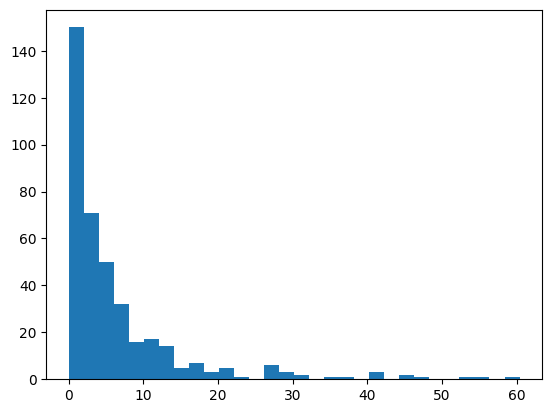

In [583]:
print([np.quantile(out['error'],i) for i in np.arange(0.1,1,0.1)])
plt.hist(out['error'],bins=30)
plt.show()

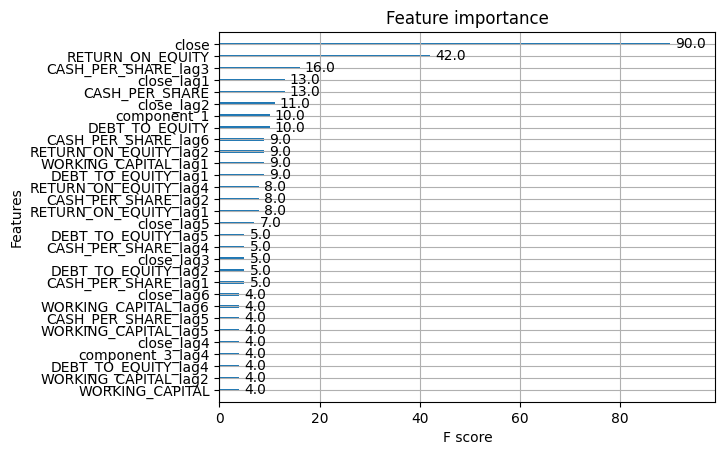

In [584]:
plot_importance(model, max_num_features=30) #### industry info is not that important
plt.show()

## Random Forest 

In [764]:
### DEPTH 6 better than DEPTH 8, 
### increasing n_estimators to 1000 doesn't improve mse/mae

### Health care, max depth 4, n_estimators 300
### Food and Beverage, max_depth 6, n_estimators 300
regressor = RandomForestRegressor(max_depth=6,random_state=1,n_estimators=300)
regressor.fit(train_X,train_y)

RandomForestRegressor(max_depth=6, n_estimators=300, random_state=1)

In [765]:
# import pickle
# pickle.dump(regressor,open(f"app/models/financial_ratios/rf_regressor_{selected.replace(' ','_').lower()}.pkl","wb"))

In [766]:
pred = regressor.predict(test_X)
mean_absolute_error(pred,test_y),mean_squared_error(pred,test_y)

(6.223952402313288, 120.06832473999813)

In [767]:
out = test_y.copy()
out['pred'] = pred
out['error'] = np.abs(out['target'] - out['pred'])
out['error_percentage'] = out['error']/out['target'] 
out = pd.concat([out,train_df],axis=1).loc[:,['target','pred','error','error_percentage','close']].dropna()
print(out.shape)
out.head()

(393, 6)


,,target,target,pred,error,error_percentage,close
date,ticker,,,,,,
2011-06-30,ACL,30.1,30.1,22.446696,7.653304,0.254263,23.9
2015-09-30,HAG,10.4,10.4,16.051173,5.651173,0.543382,14.8
2020-09-30,TAR,23.8,23.8,20.703469,3.096531,0.130106,21.2
2018-12-31,SJ1,20.0,20.0,15.581651,4.418349,0.220917,13.9
2022-06-30,VHC,84.9,84.9,98.187095,13.287095,0.156503,93.5


In [768]:
out.sort_values(by=['error_percentage'],ascending=False).head()
    

,,target,target,pred,error,error_percentage,close
date,ticker,,,,,,
2019-12-31,SJF,1.16,1.16,3.386291,2.226291,1.919216,2.18
2022-03-31,TSC,6.50,6.50,17.309284,10.809284,1.662967,16.70
2018-03-31,HHC,46.80,46.80,96.224694,49.424694,1.056083,99.00
2022-09-30,AGM,9.59,9.59,18.627976,9.037976,0.942438,15.40
2018-09-30,IDI,7.17,7.17,13.247760,6.077760,0.847665,13.35


### predict for training & test set

In [769]:
full_pred = regressor.predict(X)
# mean_absolute_error(full_pred,y),mean_squared_error(full_pred,y)

In [770]:
out = train_df.copy()
out['pred'] = full_pred
out['error'] = np.abs(out['target'] - out['pred'])
out['error_percentage'] = out['error']/out['target'] 
out = out.loc[:,['target','pred','error','error_percentage','close']].dropna()
print(out.shape)
out.head()

(1965, 5)


,,target,pred,error,error_percentage,close
date,ticker,,,,,
2011-03-31,AAM,20.5,20.949960,0.449960,0.021949,20.0
2011-06-30,AAM,24.0,21.126141,2.873859,0.119744,20.5
2011-09-30,AAM,22.3,22.665821,0.365821,0.016405,24.0
2011-12-31,AAM,24.9,22.459641,2.440359,0.098006,22.3
2012-03-31,AAM,26.5,25.891991,0.608009,0.022944,24.9


In [754]:
ticker = 'FPT'

single = out.loc[(slice(None), ticker),:]

# single['pred'] = pred.values
# single['error'] = np.abs(single['target'] - single['pred'])
# single['error_percentage'] = single['error']/single['target'] 

print(single['error_percentage'].mean(),single['error_percentage'].sum())
single.index = single.index.get_level_values('date').to_period('Q')
single.tail(20)

KeyError: 'FPT'

In [755]:
price = hp.get_asset_price(ticker,'daily').dropna()
price.index = price.index.to_period('Q')
price.head()

,low,high,open,close,adj_close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value
date,,,,,,,,,
2006Q4,400.0,400.0,400.0,400.0,13.34,83530,33412000,0,0
2006Q4,420.0,420.0,420.0,420.0,14.00,280710,117898200,96000,36480000
2006Q4,441.0,441.0,441.0,441.0,14.70,265300,116997300,30000,12200000
2006Q4,463.0,463.0,463.0,463.0,15.44,215790,99910770,10000,4410000
2006Q4,486.0,486.0,486.0,486.0,16.20,137520,66834720,0,0


In [733]:
merged = pd.merge(price.loc[:,['close','adj_close']], single.loc[:,['pred','target']], left_index=True, right_index=True)
merged.head()

,close,adj_close,pred,target
date,,,,
2013Q3,42.0,6.44,50.605496,47.1
2013Q3,42.4,6.50,50.605496,47.1
2013Q3,42.6,6.53,50.605496,47.1
2013Q3,43.4,6.66,50.605496,47.1
2013Q3,43.6,6.69,50.605496,47.1


In [734]:
capital = 3000000

initial_capital =capital
shares = 0

position_sizing = 1
multiplier = 0.01
total = capital

for i in range(len(merged)):
    prices = merged.iloc[i]
    total = shares*prices['close']*1000 + capital
    
    if prices['pred'] > (1+multiplier)*prices['close']:
        buy = np.floor(position_sizing*capital/(prices['close']*1000))
        shares+=buy
        capital-=position_sizing*capital
    elif prices['pred'] < (1-multiplier)*prices['close']:
        capital+=(prices['close']*1000)*shares
        shares = 0 
    else:
        continue
print(total)
print((total/initial_capital)-1)
print((total/initial_capital)**(250/len(merged))-1)

22188000.0
6.396
0.22190925026238806


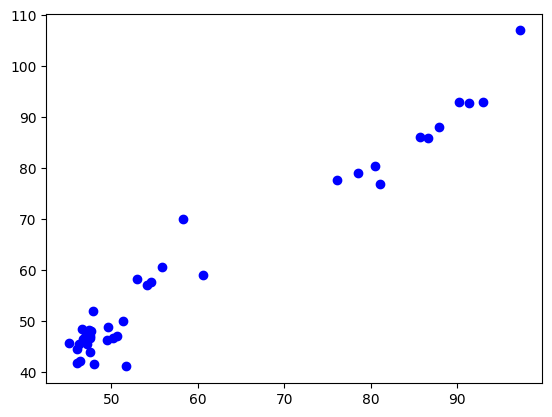

In [735]:
plt.scatter(single['pred'],single['target'],color='b')

In [736]:
def func(x, a, b ):
    return a*x + b

[ 1.06387982 -3.83120177] 51068.48419217214 13.920594279864451 2.6544502214310435


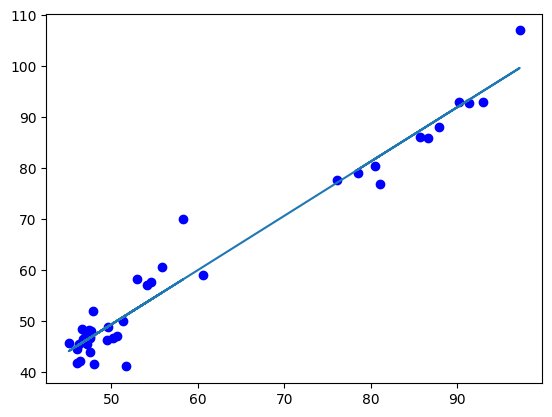

In [737]:
popt, pcov = curve_fit(func, single['pred'],single['target'])

pred = func(single['pred'], *popt)
print(popt,np.linalg.cond(pcov),mean_squared_error(single['target'],pred),mean_absolute_error(single['target'],pred))
plt.scatter( single['pred'],single['target'],color='b')
plt.plot(single['pred'], pred )

In [659]:
### WITH previous 2 months adj close, and industry 
# 3 lags, (2.398768710114873, 30.46957904207972)
# 2 lags, (2.405857670040624, 25.784690165986007)
# 1 lag (2.439708650293388, 27.271149202349363)

## WIHTOUT previos 2 months adj close, wihtout industry
## 2 lag (2.5365925678023347, 37.192373457390644)
## 3 lag (2.4248232332599535, 27.745443168738014)
## 4 lgs (2.470426647789072, 27.722115518735393)

In [771]:
grouped  = out.groupby(level=[1]).mean().sort_values(by=['error_percentage'],ascending=False)
well_behaved = grouped.loc[grouped['error_percentage']<=0.1]
grouped.shape,well_behaved.shape

((52, 5), (9, 5))

In [772]:
industry = pd.read_csv('data/tickers.csv',index_col=0)
industry = industry.loc[industry['status']=='listed',['industry','sub_industry','floor','listedDate']]
industry.head()

,industry,sub_industry,floor,listedDate
PVD,Oil & Gas,"Oil Equipment, Services & Distribution",HOSE,12/5/2006
PVC,Oil & Gas,"Oil Equipment, Services & Distribution",HNX,11/15/2007
PLX,Oil & Gas,Oil & Gas Producers,HOSE,4/21/2017
PVS,Oil & Gas,"Oil Equipment, Services & Distribution",HNX,9/20/2007
PVB,Oil & Gas,"Oil Equipment, Services & Distribution",HNX,12/24/2013


In [773]:
final = well_behaved.join(industry)
final['listedDate'] = pd.to_datetime(final['listedDate'])
final = final.loc[(final['floor']=='HOSE')]
final.sort_values(by=['error_percentage'],ascending=False)

,target,pred,error,error_percentage,close,industry,sub_industry,floor,listedDate
ticker,,,,,,,,,
SSC,50.252439,50.090912,4.958674,0.094044,50.539024,Food & Beverage,Food Producers,HOSE,2021-09-06
ABT,40.962295,41.744286,3.707464,0.090763,41.034426,Food & Beverage,Food Producers,HOSE,2021-09-06
AAM,14.172400,14.654794,1.206446,0.085411,14.362400,Food & Beverage,Food Producers,HOSE,2009-09-24
VNM,117.160000,118.169788,8.457713,0.070555,118.830000,Food & Beverage,Food Producers,HOSE,2006-01-19
NSC,88.275000,86.951034,5.745827,0.066489,88.457500,Food & Beverage,Food Producers,HOSE,2021-09-06
VCF,192.762500,188.392584,12.004481,0.063979,192.325000,Food & Beverage,Beverages,HOSE,2011-01-28
SMB,36.469643,36.577815,1.947880,0.055460,36.201786,Food & Beverage,Beverages,HOSE,2018-08-03
BAF,22.350000,21.852130,0.497870,0.022276,22.950000,Food & Beverage,Food Producers,HOSE,2021-12-03
